# Make Predictions on the Test Set and show plots

## Preliminaries: iPython magic and imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import h5py
import torch

from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

sys.path.insert(0, '../train/')
from models import TimeSeriesFCN

## Define functions that we will need later on

In [3]:
def load_data_as_tensor_datasets(file_path, shuffle_data=False, random_seed=42):

    # Set the seed for the random number generator
    np.random.seed(random_seed)

    # Read in the spectrograms from the HDF file
    with h5py.File(file_path, 'r') as file:

        x = np.array(file['timeseries'])[:64]
        y = np.array(file['labels'])[:64]

    # Swap axes around to get to NCHW format
    x = np.swapaxes(x, 1, 3)
    x = np.swapaxes(x, 2, 3)
    x = np.squeeze(x)
    
    # Convert to torch Tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()

    # Create TensorDatasets for training, test and validation
    tensor_dataset = TensorDataset(x, y)

    return tensor_dataset



def apply_model(model, data_loader, as_numpy=False):

    # Initialize an empty array for our predictions
    y_pred = []

    # Loop over the test set (in mini-batches) to get the predictions
    for mb_idx, mb_data in enumerate(data_loader):

        print(mb_idx, end=' ')
        
        # Get the inputs and wrap them in a PyTorch variable
        inputs, labels = mb_data
        inputs = Variable(inputs, volatile=True)
        labels = Variable(labels, volatile=True)

        # If CUDA is available, run everything on the GPU
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Make predictions for the given mini-batch
        outputs = model.forward(inputs)
        outputs = outputs.view((outputs.size()[0], outputs.size()[-1]))

        # Stack that onto the previous predictions
        y_pred.append(outputs)

    # Concatenate the list of Variables to one Variable (this is faster than
    # concatenating all intermediate results) and make sure results are float
    y_pred = torch.cat(y_pred, dim=0).float()

    # If necessary, convert model outputs to numpy array
    if as_numpy:
        y_pred = y_pred.data.cpu().numpy()

    return y_pred

## Read in the predictions and make plots

In [4]:
model = TimeSeriesFCN()

# Load the model weights: A little cumbersome, because we don't have CUDA
# and GPU parallelization like during training time
weights_file = '../train/weights/fwhm_findcoa/timeseries_weights_GW150914_1000_1700_4k_0.5_FWHM.net'
state_dict = torch.load(weights_file, map_location=lambda storage, loc: storage)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

In [5]:
# Path to the directory where all data is stored
data_path = '../data'

# Name of the file containing the predictions we want to inspect
file_name = 'testing_GW150914_1000_1700_4k_FWHM.h5'
file_path = os.path.join(data_path, 'testing', 'timeseries', file_name)

tensor_dataset = load_data_as_tensor_datasets(file_path)
dataloader = DataLoader(tensor_dataset, batch_size=8)

In [6]:
true_labels = tensor_dataset.target_tensor.numpy()
pred_labels = apply_model(model, dataloader, as_numpy=True)

0 1 2 3 4 5 6 7 

Index: 13


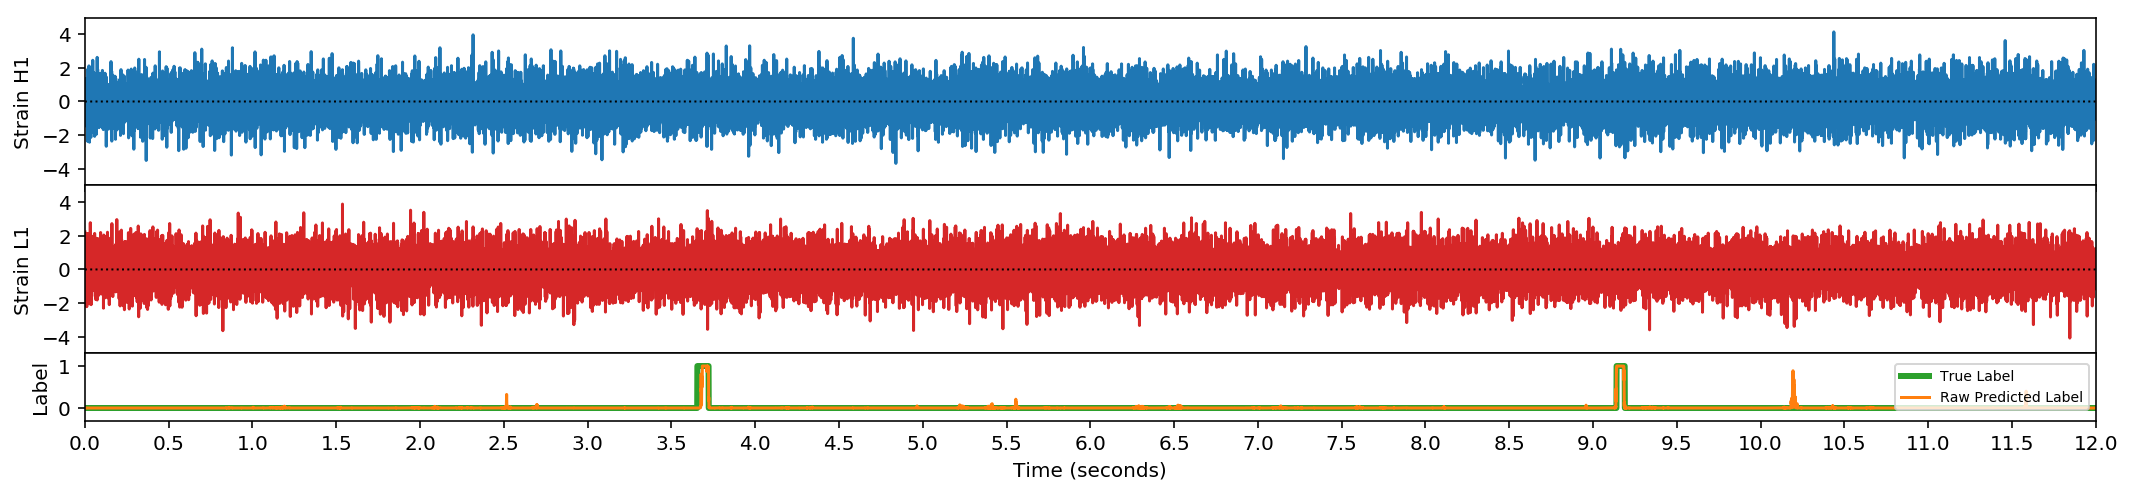

In [16]:
timeseries = tensor_dataset.data_tensor.numpy()

# Plot the first N spectrograms and the respective labels / predictions
for i in [13]: #range(5, 30):
    
    print('Index:', i)
    
    timeseries_H1 = timeseries[i, 0, :]
    timeseries_L1 = timeseries[i, 1, :]
    
    grid = np.linspace(0, 12, 12*2048)
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex='col',
                             gridspec_kw={'height_ratios': [5, 5, 2]}, 
                             figsize=(4*4.50461, 3*1.235817933))
    
    axes[0].plot(grid, timeseries_H1, color='C0')
    axes[0].plot(grid, [0 for _ in grid], color='Black', lw=1, ls=':')
    axes[0].set_ylim(-5, 5)
    axes[0].set_ylabel('Strain H1')
    
    axes[1].plot(grid, timeseries_L1, color='C3')
    axes[1].set_ylim(-5, 5)
    axes[1].plot(grid, [0 for _ in grid], color='Black', lw=1, ls=':')
    axes[1].set_ylabel('Strain L1')
    
    """
    # Calculate and plot the fuzzy-zones
    THRESHOLD = 0.5
    fuzzy_zones = -1 * np.ones(len(pred_labels[i]))
    for j in range(len(pred_labels[i])):
        if THRESHOLD < true_labels[i][j] <= 1.2*THRESHOLD:
            fuzzy_zones[j] = 1
    axes[2].fill_between(grid, -1, fuzzy_zones, color='Gray', alpha=0.5, lw=0)
    """
    
    axes[2].plot(grid, np.greater(true_labels[i], 0.5), color='C2', lw=3, label='True Label')
    axes[2].plot(grid, pred_labels[i], color='C1', lw=1.5, label='Raw Predicted Label')
    axes[2].legend(loc='center right', frameon=True, fontsize=7)
    axes[1].set_xticks(np.linspace(0, 12, 25))
    axes[1].set_xticklabels(['{:.1f}'.format(_) for _ in np.linspace(0, 12, 25)])

    axes[0].set_yticks([-4, -2, 0, 2, 4])
    axes[1].set_yticks([-4, -2, 0, 2, 4])

    
    """
    smooth_pred = np.convolve(pred_labels[i], np.ones(50), mode='same')/50
    
    axes[2].plot(grid, smooth_pred, color='Orange')
    axes[2].plot(grid, np.round(smooth_pred), color='Yellow')
    """
    
    axes[2].set_ylim(-0.3, 1.3)
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Label')
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.xlim(0, 12)
    # plt.suptitle('Time Series (H1/L1), True Label and Predicted Label', y=0.95)
    plt.savefig('fwhm_predictions.png', bbox_inches='tight', dpi=600)
    plt.show()